<a href="https://colab.research.google.com/github/bivekpok/DSPS_BPokhrel/blob/main/labs/Bpokhrel_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from copy import deepcopy

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from scipy.signal import convolve2d

from tensorflow import keras
from keras.datasets import mnist
from keras import layers

!pip install icecream
from icecream import ic

rng = np.random.RandomState(1415)

# Load MNIST data

In [12]:
# Load the data and split it between train and test sets
(Xtrn, Ytrn), (Xtst, Ytst) = mnist.load_data()

# Visualize dataset

In [13]:
Xtrn.shape, Xtst.shape, Ytrn.shape, Ytst.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [14]:
np.unique(Ytrn)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

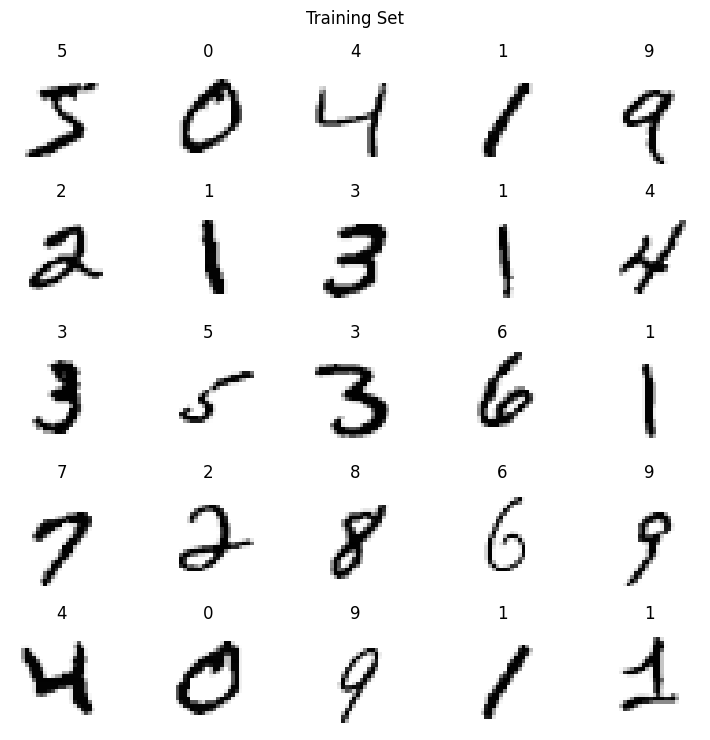

In [16]:
def plot_images(images, labels, nrows=5, ncols=5, vmin=0, vmax=255, scale=1.5, suptitle=None):
    fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(scale * ncols, scale * nrows))

    if suptitle is not None:
        fig.suptitle(suptitle)

    for i in range(nrows * ncols):
        ax = axes.flatten()[i]
        image = images[i]
        label = labels[i]

        ax.set_title(label)
        ax.imshow(image, vmin=vmin, vmax=vmax, cmap="Greys")
        ax.set_aspect("equal")
        ax.axis("off")

    fig.tight_layout()
    fig.show()

plot_images(Xtrn, Ytrn, suptitle="Training Set")

# Normalize the images

In [17]:
def normalize_255(array):
  norm_array = array/255
  return norm_array

In [18]:
XtrnN = normalize_255(Xtrn)

XtstN = normalize_255(Xtst)


In [19]:
XtrnN.min(), XtrnN.max(), XtstN.min(), XtstN.max()

(0.0, 1.0, 0.0, 1.0)

# Reshape the arrays for Keras

In [20]:
def reshape_for_keras(array):
  reshaped_array = array[...,None]
  return reshaped_array
XtrnNR = reshape_for_keras(XtrnN)
XtstNR = reshape_for_keras(XtstN)

In [22]:
Xtrn.shape, XtrnNR.shape, XtrnN.shape

((60000, 28, 28), (60000, 28, 28, 1), (60000, 28, 28))

# One-hot encode the image labels

In [28]:
num_classes = np.unique(Ytrn).size
YtrnOH = keras.utils.to_categorical(Ytrn, num_classes)
YtstOH = keras.utils.to_categorical(Ytst, num_classes)
YtstOH.shape, YtrnOH.shape

((10000, 10), (60000, 10))

# But wait we don't need the image labels...

### The training set will be the images at half resolution, and the model will try to up-sample the images to the original resolution... `Xtrn` should be the same 60,000 images at half resolution, but `Ytrn` should be those same images at the original resolution. We will do the same operations for the testing set.

# Construct dataset for superresolution, not image classification

In [30]:
def build_high_res(X):
  Xnew = deepcopy(X)[:,::2,::2,:]
  Ynew = deepcopy(X)

  return Xnew, Ynew

XtrnSR, YtrnSR = build_high_res(XtrnNR)
XtstSR, YtstSR = build_high_res(XtstNR)

# Visualize the new dataset

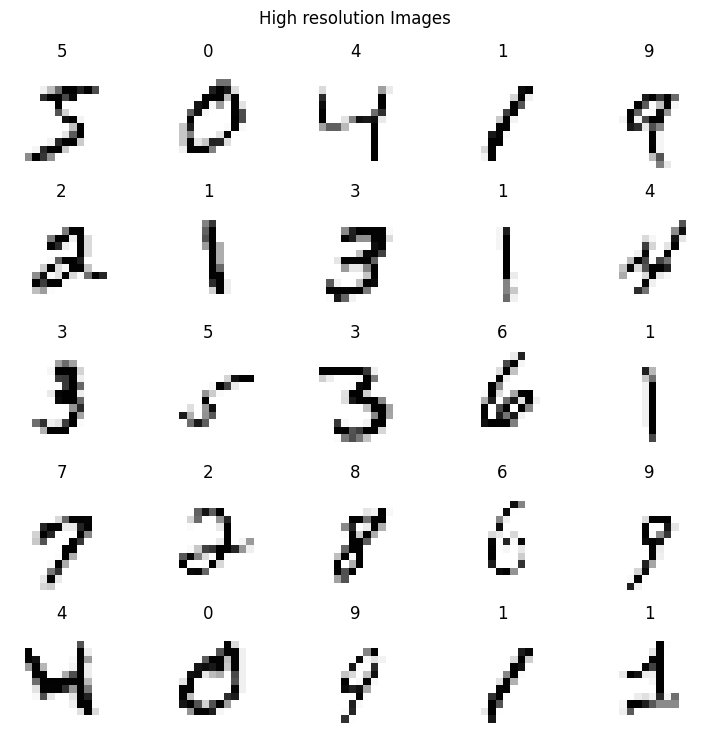

In [34]:
plot_images(XtrnSR, Ytrn, vmin=0, vmax=1, suptitle='High resolution Images')

# Build the CNN autoencoder

In [35]:
def build_cnn_autoencoder(input_shape):
  inputs = layers.Input(shape =input_shape)
  x= layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')(inputs)
  x= layers.Conv2D(8, kernel_size=(3,3), padding='same', activation='relu')(x)
  x= layers.Conv2D(4, kernel_size=(3,3), padding='same', activation='relu')(x)
  x= layers.MaxPooling2D(pool_size=(2,2))(x)

  shape = x.shape
  num_neurons = shape[1]*shape[2]*shape[3]

  x = layers.Flatten()(x)

  LS = layers.Dense(16, activation='relu')(x)

  x= layers.Dense(num_neurons, activation='relu')(LS)
  x= layers.Reshape(shape[1:])(x)
  x= layers.Conv2DTranspose(4, kernel_size= (3,3),padding ='same', activation = 'relu')(x)
  x= layers.Conv2DTranspose(8, kernel_size= (3,3),padding ='same', activation = 'relu')(x)
  x= layers.Conv2DTranspose(16, kernel_size= (3,3),padding ='same', activation = 'relu')(x)
  x = layers.UpSampling2D(size=(2,2))(x)

  x= layers.Conv2DTranspose(16, kernel_size= (3,3),padding ='same', activation = 'relu')(x)
  x= layers.Conv2DTranspose(16, kernel_size= (3,3),padding ='same',activation = 'relu')(x)
  x= layers.Conv2DTranspose(16, kernel_size= (3,3),padding ='same', activation = 'relu')(x)
  x = layers.UpSampling2D(size=(2,2))(x)

  x= layers.Conv2DTranspose(16, kernel_size= (3,3),padding ='same', activation = 'sigmoid')(x)
  x= layers.Conv2DTranspose(16, kernel_size= (3,3),padding ='same', activation = 'sigmoid')(x)
  outputs = layers.Conv2DTranspose(1, kernel_size= (3,3),padding ='same', activation = 'sigmoid')(x)

  model = keras.Model(inputs, outputs)

  encoder = keras.Model(inputs, LS)
  decoder =keras.Model(LS, outputs)


  return model, encoder, decoder

input_shape = XtrnSR.shape[1:]
model, encoder, decoder = build_cnn_autoencoder(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 4)         292       
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 4)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 196)               0         
                                                             

# Train the model (use a GPU)

In [50]:
YtrnSR.shape

(60000, 28, 28, 1)

In [36]:
model.compile(loss= 'mse', optimizer ='adam')
history = model.fit(XtrnSR, YtrnSR, batch_size=256, epochs= 10, validation_split=0.1)

Epoch 1/10
211/211 [==============================] - 139s 639ms/step - loss: 0.0787 - val_loss: 0.0486
Epoch 2/10
211/211 [==============================] - 134s 635ms/step - loss: 0.0391 - val_loss: 0.0325
Epoch 3/10
211/211 [==============================] - 134s 634ms/step - loss: 0.0303 - val_loss: 0.0288
Epoch 4/10
211/211 [==============================] - 134s 637ms/step - loss: 0.0272 - val_loss: 0.0260
Epoch 5/10
211/211 [==============================] - 134s 635ms/step - loss: 0.0255 - val_loss: 0.0248
Epoch 6/10
211/211 [==============================] - 134s 634ms/step - loss: 0.0245 - val_loss: 0.0246
Epoch 7/10
211/211 [==============================] - 134s 637ms/step - loss: 0.0237 - val_loss: 0.0232
Epoch 8/10
211/211 [==============================] - 134s 633ms/step - loss: 0.0231 - val_loss: 0.0228
Epoch 9/10
211/211 [==============================] - 134s 636ms/step - loss: 0.0227 - val_loss: 0.0227
Epoch 10/10
211/211 [==============================] - 138s 653m

# Visualize loss curve

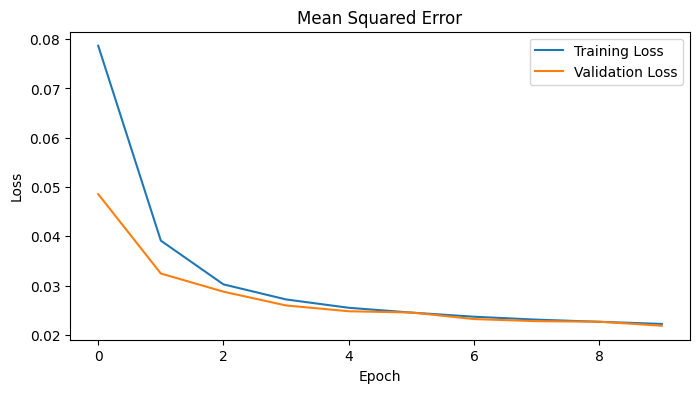

In [37]:
def plot_curves(history):
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(8, 4))

    ax.set_title("Mean Squared Error")
    ax.plot(history["loss"], label="Training Loss")
    ax.plot(history["val_loss"], label="Validation Loss")
    ax.legend(loc="upper right")
    ax.set_ylabel("Loss")

    ax.set_xlabel("Epoch")

plot_curves(history.history)

# Visualize the predictions

In [38]:
PtstSR = model.predict(XtstSR)
PtstSR.shape

313/313 [==============================] - 12s 37ms/step


(10000, 28, 28, 1)

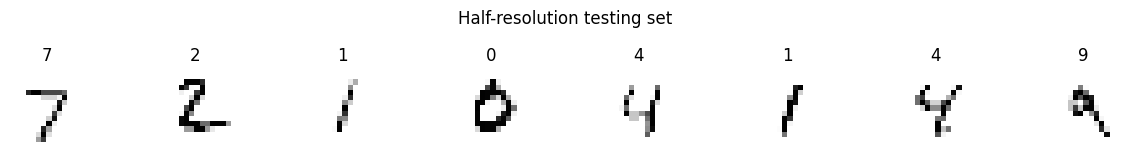

In [39]:
plot_images(XtstSR[...,0] ,Ytst, nrows =1, ncols =8, vmin=0, vmax=1, suptitle="Half-resolution testing set")

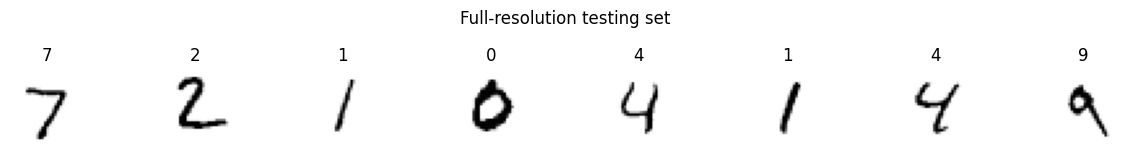

In [41]:
plot_images(YtstSR[..., 0], Ytst, nrows=1, ncols=8, vmin=0, vmax=1, suptitle="Full-resolution testing set")

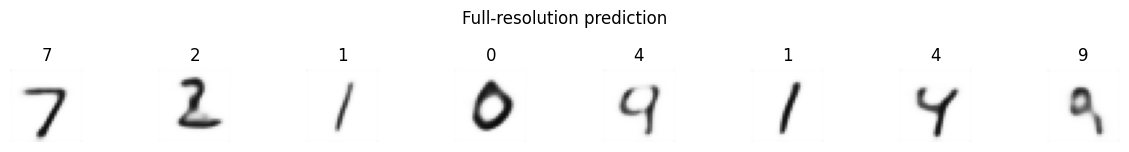

In [42]:
plot_images(PtstSR[..., 0], Ytst, nrows=1, ncols=8, vmin=0, vmax=1, suptitle="Full-resolution prediction")

# Visualize the early layers

In [43]:
def plot_kernels_on_image(image, layer, plot_kernels=False):
    kernels = layer.get_weights()[0][:, :, 0, :]
    num_kernels = kernels.shape[-1]

    fig, axes = plt.subplots(1, num_kernels, sharex=True, sharey=True, figsize=(16, 6))

    for i in range(num_kernels):
        kernel = kernels[:, :, i]
        ax = axes.flatten()[i]

        if plot_kernels:
            ax.imshow(kernel, cmap="Greys")

        else:
            convolved_image = convolve2d(image, kernel, mode="same")
            ax.imshow(convolved_image, cmap="Greys")

        ax.set_aspect("equal")
        ax.axis("off")

    fig.tight_layout()
    fig.show()

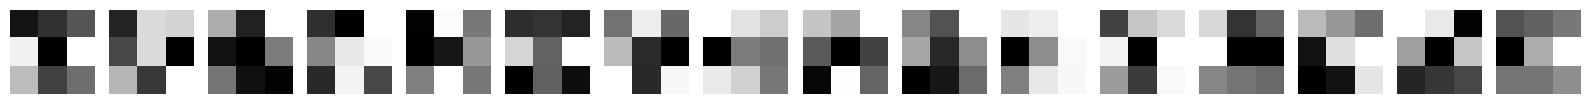

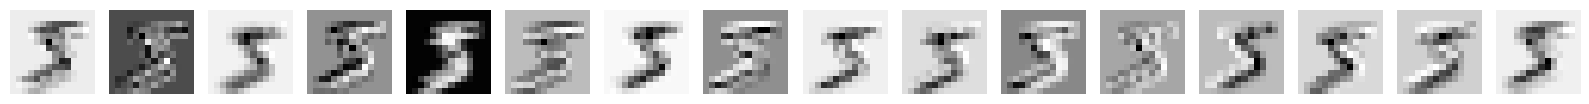

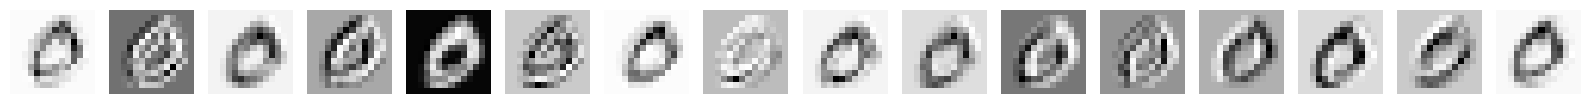

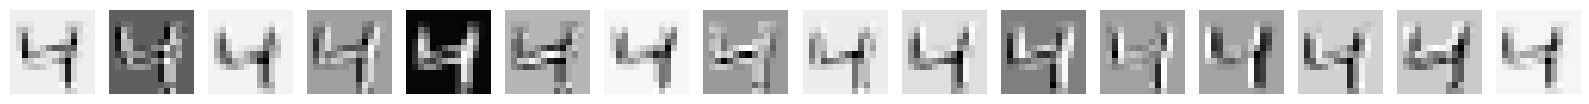

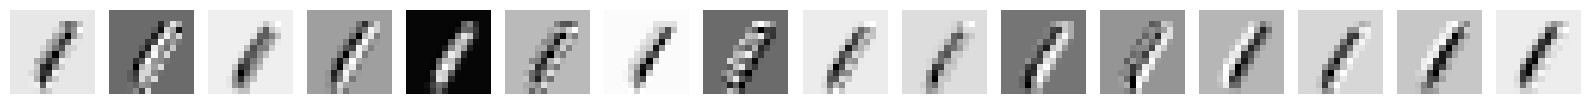

In [44]:
plot_kernels_on_image(XtrnSR[0, :, :, 0], model.layers[1], plot_kernels=True)
plot_kernels_on_image(XtrnSR[0, :, :, 0], model.layers[1])
plot_kernels_on_image(XtrnSR[1, :, :, 0], model.layers[1])
plot_kernels_on_image(XtrnSR[2, :, :, 0], model.layers[1])
plot_kernels_on_image(XtrnSR[3, :, :, 0], model.layers[1])

# Visualize the latent space with the encoder and decoder on their own

In [45]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 4)         292       
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 4)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 196)               0         
                                                           

In [46]:
LS = encoder.predict(XtstSR)
ic(LS.shape)

LS_images = LS.reshape((10_000, 4, 4))

313/313 [==============================] - 2s 5ms/step


ic| LS.shape: (10000, 16)


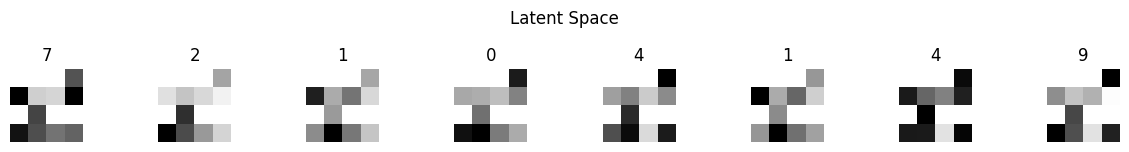

In [47]:
plot_images(LS_images, Ytst, nrows=1, ncols=8, vmin=None, vmax=None, suptitle="Latent Space")

# Find the average latent space representation for each digit

# Decode latent space representations with the decoder

In [48]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 196)               3332      
                                                                 
 reshape (Reshape)           (None, 7, 7, 4)           0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 4)           148       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 7, 7, 8)           296       
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 7, 7, 16)          1168

In [49]:
output = decoder.predict(LS)
output.shape

313/313 [==============================] - 10s 33ms/step


(10000, 28, 28, 1)

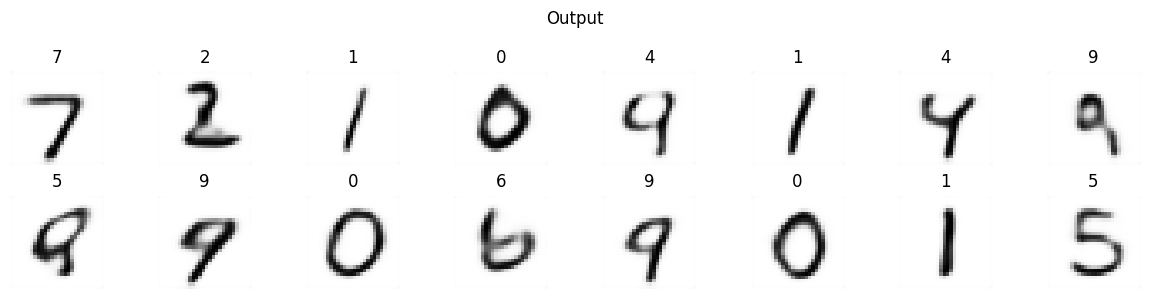

In [50]:
plot_images(output[..., 0], Ytst, nrows=2, ncols=8, vmin=None, vmax=None, suptitle="Output")

# What if we input something in the latent space by hand and then decode it?

313/313 [==============================] - 8s 26ms/step


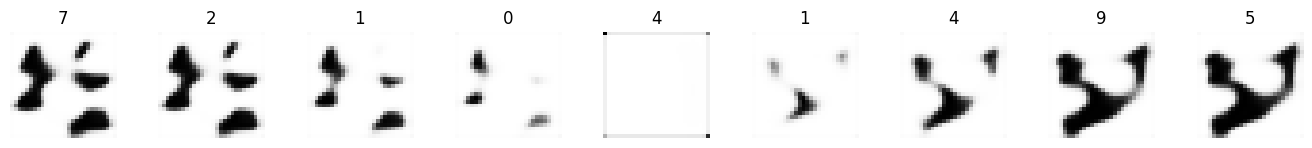

In [51]:
LS_manual = np.zeros_like(LS)

# Try one image set to -100
LS_manual[0] = -100
LS_manual[1] = -50
LS_manual[2] = -10
LS_manual[3] = -5
LS_manual[4] = 0
LS_manual[5] = 5
LS_manual[6] = 10
LS_manual[7] = 50
LS_manual[8] = 100

output = decoder.predict(LS_manual)
plot_images(output[..., 0], Ytst, nrows=1, ncols=9, vmin=None, vmax=None)

313/313 [==============================] - 9s 30ms/step


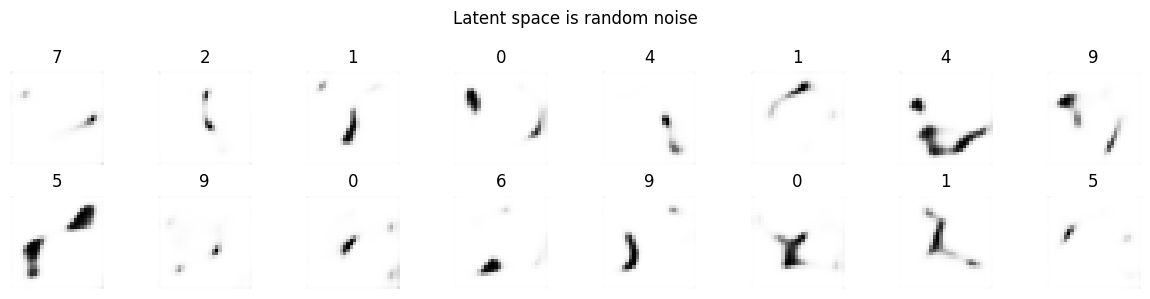

In [52]:
# Try all random noise between -10 and 10:
from scipy import stats

LS_manual = stats.uniform.rvs(loc=-10, scale=20, size=LS.shape)
output = decoder.predict(LS_manual)
plot_images(output[..., 0], Ytst, nrows=2, ncols=8, vmin=None, vmax=None, suptitle="Latent space is random noise")